<a href="https://colab.research.google.com/github/RiseAboveAll/PYTORCH_Learning/blob/master/Improved_Functional_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [25]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchsummary import summary

## Load Dataset

In [5]:
transformer_train=transforms.Compose([transforms.RandomCrop(32,padding=4),transforms.RandomHorizontalFlip(p=.5),transforms.RandomAffine(0,translate=(.1,.1)),transforms.ToTensor()])

In [6]:
train_dataset=torchvision.datasets.CIFAR10(root='.',train=True,transform=transformer_train,download=True)
test_dataset=torchvision.datasets.CIFAR10(root='.',train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
#We can see the data is not in tensor form , rather it is in numpy array form
train_dataset.data.shape

(50000, 32, 32, 3)

In [7]:
K=len(set(train_dataset.targets))

In [8]:
#Number of Classes
K

10

## Data Loader

In [10]:
batch_size=128
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

## Model Buidling :

In [17]:
class CNN(nn.Module):
  def __init__(self,K):
    super(CNN,self).__init__()
    #Define Convolution Layer
    self.conv1=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(),
        #Batchnorm Number of feature will be equal to out_channels of previous convolution layer
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )
    self.conv2=nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(),
        #Batchnorm Number of feature will be equal to out_channels of previous convolution layer
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )
    self.conv3=nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(),
        #Batchnorm Number of feature will be equal to out_channels of previous convolution layer
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )
    #Define Dense Layer
    self.Dense1=nn.Linear(128*4*4,1024)
    self.Dense2=nn.Linear(1024,K)
  def forward(self,X):
    X=self.conv1(X)
    X=self.conv2(X)
    X=self.conv3(X)
    X=X.view(X.size(0),-1)
    X=F.dropout(X,p=.5)
    X=F.relu(self.Dense1(X))
    X=F.dropout(X,p=.2)
    X=self.Dense2(X)
    return X


In [18]:
model=CNN(K)

In [19]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [20]:
#Loss & Optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.0001)

In [21]:
# Function to Encapsulate training
def batch_gradient(model,criterion,optimizer,train_loader,test_loader,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for inputs,targets in train_loader:
      #Move Data to GPU
      inputs,targets=inputs.to(device),targets.to(device)
      #Zero the parameter Gradient
      optimizer.zero_grad()
      #Forward Pass
      outputs=model(inputs)
      loss=criterion(outputs,targets)
      #Bacward Pass
      loss.backward()
      #Perform single optmization step
      optimizer.step()

      train_loss.append(loss.item())

    #Get train loss and test loss
    train_loss=np.mean(train_loss)
    test_loss=[]
    for inputs,targets in test_loader:
      #Move Data to GPU
      inputs,targets=inputs.to(device),targets.to(device)
      outputs=model(inputs)
      loss=criterion(outputs,targets)
      test_loss.append(loss.item())
    test_loss=np.mean(test_loss)

    #Save Losses
    train_losses[it]=train_loss
    test_losses[it]=test_loss
    dt=datetime.now()-t0
    print(f'Epoch {it+1}/{epochs},Duration : {dt} , Train Loss : {train_loss : .4f},  Test Loss : {test_loss : .4f}')
  return train_losses,test_losses






In [22]:
train_losses,test_losses=batch_gradient(model,criterion,optimizer,train_loader,test_loader,50)

Epoch 1/50,Duration : 0:00:42.936566 , Train Loss :  1.6404,  Test Loss :  1.3898
Epoch 2/50,Duration : 0:00:42.882573 , Train Loss :  1.3328,  Test Loss :  1.2028
Epoch 3/50,Duration : 0:00:42.928132 , Train Loss :  1.1749,  Test Loss :  1.0851
Epoch 4/50,Duration : 0:00:42.750539 , Train Loss :  1.0590,  Test Loss :  1.0312
Epoch 5/50,Duration : 0:00:42.817687 , Train Loss :  0.9803,  Test Loss :  0.9265
Epoch 6/50,Duration : 0:00:42.934659 , Train Loss :  0.9098,  Test Loss :  0.8758
Epoch 7/50,Duration : 0:00:43.274757 , Train Loss :  0.8627,  Test Loss :  0.8466
Epoch 8/50,Duration : 0:00:43.316394 , Train Loss :  0.8158,  Test Loss :  0.7982
Epoch 9/50,Duration : 0:00:43.209715 , Train Loss :  0.7782,  Test Loss :  0.7894
Epoch 10/50,Duration : 0:00:43.342237 , Train Loss :  0.7385,  Test Loss :  0.7609
Epoch 11/50,Duration : 0:00:43.342129 , Train Loss :  0.7193,  Test Loss :  0.7392
Epoch 12/50,Duration : 0:00:43.175682 , Train Loss :  0.6936,  Test Loss :  0.7258
Epoch 13/50,D

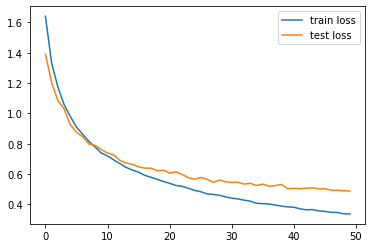

In [23]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [24]:
# Accuracy

n_correct=0
n_total=0
for inputs,targets in train_loader:
  #Move data to GPU
  inputs,targets=inputs.to(device),targets.to(device)
  #Forward Pass
  outputs=model(inputs)
  #Get Prediction
  _,predictions=torch.max(outputs,1)
  #update counts
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total
n_correct=0
n_total=0
for inputs,targets in test_loader:
  #Move data to GPU
  inputs,targets=inputs.to(device),targets.to(device)
  #Forward Pass
  outputs=model(inputs)
  #Get Prediction
  _,predictions=torch.max(outputs,1)
  #update counts
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
test_acc=n_correct/n_total
print(f'Train Acc : {train_acc:.4f}, Test Acc : {test_acc:.4f}')

Train Acc : 0.8828, Test Acc : 0.8360


## Model Summary

In [26]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6